# MAI - Deep Learning: Autonomous Lab 01

Jamie Arjona Martínez

In [1]:
from __future__ import division
from pathlib import Path
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import ipdb
from ipdb import set_trace as bp

import keras
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import plot_model
from keras.models import model_from_json #to load a model from a json file.
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
np.random.seed(12345678)
import pandas as pd

%matplotlib inline

Using TensorFlow backend.


## Feedforward NN


### The code

In [69]:
#global variables
plots_folder = Path("plots/")
models_folder = Path("models/")
times_dict = {"Compilation time": [], "Training time": []}
total_history = []
text_file = "score file.txt"
train_scores = []
evaluation_scores = []

#neural net architecture config
n_hlayers = 0
n_neurons = 401
initial_neurons = 128
neurons_step = 10
n_epochs= 20
n_batch_size= 128
    
text_file =  model_name + "_" + text_file

start_time = time.clock()
print("Using keras version %s" % keras.__version__)

#Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()  # loading of MNIST dataset

#check sizes
print("\n")
print("Number of training examples: '{0}'".format(x_train.shape[0]))
print("Size of train samples: '{0}'".format(x_train.shape[1:]))
print("Size of test samples: '{0}'".format(x_test.shape[1:]))

#Data to 1D and normalization
x_train = x_train.reshape(60000, 784) #60000 observations of 784 features
x_test = x_test.reshape(10000, 784) # 10000 observations of 784 features

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

# Adapts labels to one hot encoding vector for softmax classifier
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
    
#Neural network architecture
if n_neurons==0:
    neurons=64
    model_name = "fnn_fixed_neurons"
    text_file = model_name + "_" + text_file
    for layers in range(n_hlayers):
        nn = Sequential()
        nn.add(Dense(initial_neurons, activation='relu', input_shape=(784,)))
        for i in range(layers):
            nn.add(Dense(neurons, activation = 'relu'))
        nn.add(Dense(10, activation='softmax'))

        #Model visualization
        #The plot of the model needs pydot, graphviz and pydot-ng
        #plot_model(nn, to_file='nn.png', show_shapes = True)

        #Compile the model
        time_compiling = time.clock()
        nn.compile(optimizer = 'sgd', loss='categorical_crossentropy', metrics = ['accuracy'])
        print("Compiling the network time {0} with layers equal to {1}".format(time.clock() - time_compiling, layers + 1))
        times_dict["Compilation time"].append(time.clock() - time_compiling)
        time_training = time.clock()
        #train the model
        history = nn.fit(x_train, y_train, batch_size = n_batch_size, epochs=n_epochs, validation_data=(x_test,y_test))
        print("Training time {0} with layers equal to {1}".format(time.clock() - time_training, layers + 1))
        times_dict["Training time"].append(time.clock() - time_training)
        train_scores.append((history.history["acc"][-1], history.history["loss"][-1]))

        #Evaluate the model
        score = nn.evaluate(x_test, y_test, verbose=0) #returns loss and metrics (accuracy)
        evaluation_scores.append(score)

        with open('{}'.format(text_file), 'a') as f:
            f.write("Scores for neural network with {} layers: \n".format(layers + 1))
            f.write("Loss {}".format(score[0]))
            f.write("\n")
            f.write("Accuracy {}".format(score[1]))
            f.write("\n\n")

        #Store plots
        # Accuracy plot
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plot_name = "model_accuracy_with_{}_layers_and_{}_neurons.pdf".format(layers+1, neurons)
        plt.savefig(plots_folder / plot_name)
        plt.close()
        # Loss plot
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plot_name = 'model_loss_with_{}_layers_{}_neurons.pdf'.format(layers + 1, neurons)
        plt.savefig(plots_folder / plot_name)
        plt.close()

        total_history.append(history)

        # Confusion Matrix
        # Compute probabilities
        Y_pred = nn.predict(x_test)
        # Assign most probable label
        y_pred = np.argmax(Y_pred, axis=1)
        # Plot statistics
        print('Analysis of results')
        target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
        print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
else:
    layers = 2
    model_name = "fnn_fixed_layers"
    text_file = model_name + "_" + text_file
    for neurons in range(2, n_neurons, neurons_step):
        nn = Sequential()
        nn.add(Dense(initial_neurons, activation='relu', input_shape=(784,)))
        for i in range(layers):
            nn.add(Dense(neurons, activation = 'relu'))
        nn.add(Dense(10, activation='softmax'))

        #Model visualization
        #The plot of the model needs pydot, graphviz and pydot-ng
        #plot_model(nn, to_file='nn.png', show_shapes = True)

        #Compile the model
        time_compiling = time.clock()
        nn.compile(optimizer = 'sgd', loss='categorical_crossentropy', metrics = ['accuracy'])
        times_dict["Compilation time"].append(time.clock() - time_compiling)
        time_training = time.clock()
        #train the model
        history = nn.fit(x_train, y_train, batch_size = n_batch_size, epochs=n_epochs, validation_data=(x_test,y_test))
        times_dict["Training time"].append(time.clock() - time_training)
        train_scores.append((history.history["acc"][-1], history.history["loss"][-1]))

        #Evaluate the model
        score = nn.evaluate(x_test, y_test, verbose=0) #returns loss and metrics (accuracy)
        evaluation_scores.append(score)

        with open('{}'.format(text_file), 'a') as f:
            f.write("Scores for neural network with {} layers: \n".format(layers + 1))
            f.write("Loss {}".format(score[0]))
            f.write("\n")
            f.write("Accuracy {}".format(score[1]))
            f.write("\n\n")

        #Store plots
        # Accuracy plot
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plot_name = "model_accuracy_with_{}_layers_and_{}_neurons.pdf".format(layers+1, neurons)
        plt.savefig(plots_folder / plot_name)
        plt.close()
        # Loss plot
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plot_name = 'model_loss_with_{}_layers_{}_neurons.pdf'.format(layers + 1, neurons)
        plt.savefig(plots_folder / plot_name)
        plt.close()

        total_history.append(history)

        # Confusion Matrix
        # Compute probabilities
        Y_pred = nn.predict(x_test)
        # Assign most probable label
        y_pred = np.argmax(Y_pred, axis=1)
        # Plot statistics
        print('Analysis of results')
        target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
        print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

#Execution time
print("\n\n\n\n ########################## FINISHED ##########################")
print("\n Total execution time {}".format(time.clock()-start_time))

# Ejemplo Confunde el 0 con el 6 (7 errores), el 9 con el 4 (20 errores) y el 3 con el 8 (21 errores).
#La NN tiene un 96% accuracy

Using keras version 2.2.2


Number of training examples: '60000'
Size of train samples: '(28, 28)'
Size of test samples: '(28, 28)'
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 66us/step - loss: 2.1193 - acc: 0.1907 - val_loss: 2.0099 - val_acc: 0.2334
Epoch 2/20
60000/60000 [==============================] - 2s 38us/step - loss: 1.9285 - acc: 0.2879 - val_loss: 1.8507 - val_acc: 0.3061
Epoch 3/20
60000/60000 [==============================] - 2s 38us/step - loss: 1.8212 - acc: 0.3080 - val_loss: 1.7815 - val_acc: 0.3216
Epoch 4/20
60000/60000 [==============================] - 2s 38us/step - loss: 1.7572 - acc: 0.3185 - val_loss: 1.7204 - val_acc: 0.3275
Epoch 5/20
60000/60000 [==============================] - 2s 38us/step - loss: 1.7034 - acc: 0.3260 - val_loss: 1.6766 - val_acc: 0.3361
Epoch 6/20
60000/60000 [==============================] - 2s 39us/step - loss: 1.6662 - acc: 0.3335 - val_loss: 1.6446 - val_acc: 0.3

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.98      0.96      0.97      1135
           2       0.28      0.02      0.03      1032
           3       0.60      0.78      0.68      1010
           4       0.84      0.91      0.87       982
           5       0.73      0.66      0.69       892
           6       0.36      0.89      0.51       958
           7       0.92      0.89      0.90      1028
           8       0.65      0.12      0.20       974
           9       0.82      0.87      0.84      1009

   micro avg       0.70      0.70      0.70     10000
   macro avg       0.71      0.70      0.66     10000
weighted avg       0.71      0.70      0.67     10000

[[ 907    0    0   17    0   48    1    7    0    0]
 [   0 1093    1    1   23    0    7    0    1    9]
 [   1    0   16   63   32    7  875    4   27    7]
 [   7    0    1  791    0  147   25   17   13    9]
 [   0   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.97      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.96      0.95      0.95       982
           5       0.97      0.93      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.93      0.93       974
           9       0.95      0.94      0.94      1009

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[ 959    0    3    3    0    4    4    2    4    1]
 [   0 1116    2    2    0    1    4    2    8    0]
 [   4    1  997    3    4    0    2    7   10    4]
 [   2    1   15  959    0    8    0   12   10    3]
 [   2   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.93      0.97      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.96      0.93      0.95       892
           6       0.96      0.96      0.96       958
           7       0.97      0.94      0.95      1028
           8       0.95      0.93      0.94       974
           9       0.95      0.94      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 961    1    2    1    0    4    6    4    1    0]
 [   0 1114    2    2    1    1    4    2    9    0]
 [   3    2  995   10    4    2    2    4   10    0]
 [   0    1    9  975    1    6    0    9    8    1]
 [   2   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.93      0.97      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.93      0.94       892
           6       0.96      0.95      0.96       958
           7       0.97      0.94      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    2    2    0    5    3    1    1    0]
 [   0 1121    3    2    0    2    1    2    4    0]
 [   6    1  993   12    3    1    3    4    7    2]
 [   0    0    7  982    0    2    0    8   11    0]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.93      0.96      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.95      0.94      0.94       892
           6       0.97      0.96      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.96      0.93      0.94       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 970    0    1    1    0    3    2    1    1    1]
 [   0 1118    2    2    0    2    1    2    8    0]
 [   6    4  978   15    9    1    6    4    9    0]
 [   1    0    6  972    0    8    0   10    9    4]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.96      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.96      0.94      0.95       892
           6       0.96      0.97      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.96      0.94      0.95       974
           9       0.94      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 967    0    1    2    1    4    3    2    0    0]
 [   0 1122    3    1    0    1    2    1    5    0]
 [   6    2  985    8    8    0    5   10    5    3]
 [   1    1   13  967    0    7    0    8    7    6]
 [   2   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.95      0.96       892
           6       0.96      0.97      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.96      0.94      0.95       974
           9       0.94      0.95      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 962    0    0    3    0    3    7    2    1    2]
 [   0 1119    2    3    0    1    3    1    6    0]
 [   6    3  989    9    3    0    4    8    8    2]
 [   1    0   12  969    0   11    0    9    5    3]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.93      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.93      0.94       892
           6       0.95      0.96      0.96       958
           7       0.95      0.96      0.95      1028
           8       0.97      0.92      0.94       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 962    0    1    1    0    4    7    3    1    1]
 [   0 1117    2    2    1    1    4    3    5    0]
 [   5    3  990   10    3    2    2    8    7    2]
 [   0    0    6  974    0   10    0   11    5    4]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.95      0.95      1010
           4       0.96      0.95      0.96       982
           5       0.96      0.94      0.95       892
           6       0.95      0.96      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.94      0.95      0.94       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 967    0    1    0    0    2    7    1    2    0]
 [   0 1118    3    2    0    1    4    2    5    0]
 [   7    1  992    3    4    1    4   10    9    1]
 [   1    2   10  958    0   12    0    9   12    6]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.96      0.95      0.96       982
           5       0.96      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.97      0.95      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.94      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 963    0    1    3    0    4    5    1    2    1]
 [   0 1119    2    1    0    1    5    2    5    0]
 [   7    1  988   10    4    2    6    5    6    3]
 [   0    0    3  974    0   13    0    8    9    3]
 [   1   

42

22

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.96      0.95      0.96      1010
           4       0.96      0.95      0.95       982
           5       0.96      0.95      0.95       892
           6       0.95      0.97      0.96       958
           7       0.97      0.94      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.94      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 965    0    1    2    0    4    6    1    1    0]
 [   0 1117    3    2    0    1    4    2    6    0]
 [   8    1  996    7    4    0    5    6    4    1]
 [   1    1   14  963    0   10    0   10    8    3]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.96      0.95      0.95       892
           6       0.96      0.96      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.94      0.95      0.94       974
           9       0.97      0.92      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 967    0    1    2    0    2    5    2    1    0]
 [   0 1111    3    2    0    2    3    2   12    0]
 [   4    0  999    6    4    1    4    7    6    1]
 [   1    0    9  966    0   11    0    9   12    2]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.93      0.96      0.95      1010
           4       0.96      0.95      0.96       982
           5       0.96      0.94      0.95       892
           6       0.96      0.96      0.96       958
           7       0.95      0.95      0.95      1028
           8       0.96      0.93      0.94       974
           9       0.94      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 965    0    0    1    0    5    3    4    1    1]
 [   0 1117    3    2    0    1    3    3    6    0]
 [   6    1  992    8    4    1    4    9    6    1]
 [   0    0    8  973    0    7    0   10   10    2]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.95      0.95      1032
           3       0.96      0.95      0.95      1010
           4       0.94      0.97      0.96       982
           5       0.96      0.94      0.95       892
           6       0.95      0.96      0.96       958
           7       0.95      0.96      0.95      1028
           8       0.95      0.93      0.94       974
           9       0.96      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 964    0    1    2    0    4    6    1    1    1]
 [   0 1121    2    2    0    0    3    1    6    0]
 [   8    3  982    6    6    0    6   10   11    0]
 [   1    1   11  960    0    8    1   13   11    4]
 [   2   

42

24

1

14

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.91      0.97      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.97      0.93      0.95       892
           6       0.96      0.96      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.97      0.92      0.95       974
           9       0.95      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    1    3    0    4    4    1    1    0]
 [   0 1120    4    2    1    0    4    1    3    0]
 [   6    1  991    9    7    1    5    8    3    1]
 [   1    0    5  982    0    3    0    8    6    5]
 [   2   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.96      0.94      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.93      0.94       892
           6       0.95      0.96      0.95       958
           7       0.97      0.94      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.94      0.95      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 968    0    0    1    0    3    6    1    1    0]
 [   0 1118    3    2    0    1    4    1    6    0]
 [  10    3  988    3    5    1    9    4    8    1]
 [   2    1   12  954    0   12    0    8   14    7]
 [   1   

42

24

1

14

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.95      0.96      0.96      1010
           4       0.94      0.97      0.96       982
           5       0.96      0.94      0.95       892
           6       0.96      0.96      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.94      0.95      0.94       974
           9       0.96      0.92      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 960    0    0    2    0    5    9    2    1    1]
 [   0 1110    3    2    0    0    4    2   14    0]
 [   6    2  984    7    6    1    6   10   10    0]
 [   1    0    6  973    0   10    0    8   10    2]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.95      0.96      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.95      0.93      0.94       892
           6       0.96      0.96      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.94      0.95      0.94       974
           9       0.96      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 964    0    1    0    0    4    5    3    2    1]
 [   0 1116    3    2    0    1    3    2    8    0]
 [   7    3  986    9    6    1    4   10    6    0]
 [   0    2   14  958    0   12    0   11   10    3]
 [   1   

42

24

1

14

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.97      0.96      1032
           3       0.94      0.95      0.94      1010
           4       0.95      0.96      0.96       982
           5       0.95      0.94      0.95       892
           6       0.96      0.96      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.95      0.92      0.94       974
           9       0.96      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    1    3    0    3    4    2    1    0]
 [   0 1115    3    2    0    1    3    2    9    0]
 [   5    1  998    8    5    0    2    7    4    2]
 [   0    0   15  960    0    9    1   10   13    2]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.95      0.96      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.95      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 963    0    0    2    0    4    6    3    2    0]
 [   0 1116    2    2    0    1    4    2    8    0]
 [   8    3  980    9    4    3    6    9    8    2]
 [   0    0    7  974    0   10    0   10    9    0]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.96      0.94      0.95       892
           6       0.96      0.97      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.95      0.94      0.94       974
           9       0.95      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    0    2    0    4    5    1    2    0]
 [   0 1119    3    2    0    1    4    2    4    0]
 [   7    2  993    8    4    1    2    8    6    1]
 [   0    0   11  965    0   10    0   10   12    2]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.93      0.96      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.94      0.94      0.94       892
           6       0.96      0.96      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.97      0.92      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    1    2    0    3    6    1    1    0]
 [   0 1113    3    1    0    1    5    2   10    0]
 [   6    1  985   13    4    3    3    8    9    0]
 [   0    0    8  970    0   16    0    8    7    1]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.95      0.95       892
           6       0.95      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.95      0.95      0.95       974
           9       0.95      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 962    0    1    2    0    4    7    1    3    0]
 [   0 1118    3    2    0    1    4    2    5    0]
 [   6    2  984   12    7    0    5   10    6    0]
 [   1    2    7  965    0   11    0   11   10    3]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.95      0.95      1010
           4       0.94      0.97      0.95       982
           5       0.95      0.95      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.94      0.95      0.95       974
           9       0.97      0.91      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 966    0    1    1    0    2    5    3    2    0]
 [   0 1116    3    2    0    1    4    2    7    0]
 [   6    2  991    6    3    2    6    9    6    1]
 [   0    1    9  957    0   16    1   11   12    3]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.96      0.94      0.95       892
           6       0.95      0.96      0.96       958
           7       0.94      0.96      0.95      1028
           8       0.96      0.94      0.95       974
           9       0.96      0.92      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 967    0    1    2    0    3    4    2    1    0]
 [   0 1116    3    2    0    1    4    2    7    0]
 [   6    1  987    7    5    2    8    9    7    0]
 [   1    0   14  963    0   12    0   11    7    2]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.95      0.95       892
           6       0.95      0.97      0.96       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.94      0.95       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 960    0    1    2    0    5    7    3    1    1]
 [   0 1114    3    2    1    1    5    1    8    0]
 [   4    1  992    5    7    2    6    9    6    0]
 [   1    0   13  965    0   10    0    8    9    4]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.94      0.95      0.94       892
           6       0.95      0.98      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.97      0.92      0.94       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 965    0    1    1    0    3    6    1    2    1]
 [   0 1120    3    1    0    1    4    2    4    0]
 [   6    1  990    7    6    1    8    7    6    0]
 [   0    1    9  961    0   15    0   13    6    5]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.96      0.95      0.95       982
           5       0.95      0.95      0.95       892
           6       0.94      0.96      0.95       958
           7       0.95      0.96      0.96      1028
           8       0.97      0.92      0.95       974
           9       0.94      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 962    0    0    2    0    4    8    3    1    0]
 [   0 1119    1    3    1    1    3    2    5    0]
 [   7    3  985    9    3    1    9    8    6    1]
 [   1    0   11  966    0    8    0   10    6    8]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.96      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.97      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.94      0.95      0.94       974
           9       0.96      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 964    0    1    2    1    2    8    1    1    0]
 [   0 1114    2    2    1    1    5    2    8    0]
 [   5    1  999    5    3    0    6    7    5    1]
 [   0    0   13  966    0    8    1    8   13    1]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.97      0.95      0.96       982
           5       0.95      0.95      0.95       892
           6       0.95      0.96      0.96       958
           7       0.95      0.95      0.95      1028
           8       0.97      0.93      0.95       974
           9       0.94      0.95      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 958    0    1    1    0    8    5    6    1    0]
 [   0 1119    3    2    0    1    3    2    5    0]
 [   8    1  985   10    3    1    9   10    3    2]
 [   0    1    7  973    0   12    0    8    5    4]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.96      0.95      1032
           3       0.94      0.95      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.94      0.95      0.94       892
           6       0.96      0.96      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.94      0.95       974
           9       0.96      0.93      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 963    0    1    3    0    5    5    1    1    1]
 [   0 1119    2    2    0    2    3    2    5    0]
 [   7    2  986    9    6    1    3   10    8    0]
 [   0    0   14  963    0   15    0   10    6    2]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.94      0.95      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.95      0.94       974
           9       0.94      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 963    0    1    2    0    5    5    2    1    1]
 [   0 1114    1    3    0    1    5    2    9    0]
 [   6    2  980   10    3    0   10   10   10    1]
 [   1    1    8  964    0    9    0    9   16    2]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.96      0.95      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.96      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.95      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 962    0    1    0    0    4    8    1    3    1]
 [   0 1116    2    2    1    1    4    2    7    0]
 [   5    1  996    5    3    0    4    8    8    2]
 [   2    0   13  956    0   10    0   12   14    3]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.95      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.97      0.96      0.96      1028
           8       0.93      0.95      0.94       974
           9       0.97      0.92      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 965    0    1    1    0    4    5    2    1    1]
 [   0 1113    3    2    0    1    4    3    9    0]
 [   7    1  991    9    3    1    8    5    7    0]
 [   1    1   11  963    0   12    0    7   15    0]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.95      0.96      1010
           4       0.95      0.97      0.96       982
           5       0.96      0.96      0.96       892
           6       0.95      0.96      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.94      0.94       974
           9       0.96      0.93      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 967    0    0    1    0    4    5    2    1    0]
 [   0 1118    3    2    0    1    3    1    7    0]
 [   7    3  991    5    4    2    6    9    5    0]
 [   0    0   14  961    0   13    0    9   12    1]
 [   1   

42

24

1

14

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.94      0.95      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.94      0.95      0.95       892
           6       0.94      0.97      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.93      0.95       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 963    0    1    1    0    4    7    3    1    0]
 [   0 1119    1    3    0    1    4    2    5    0]
 [   9    2  987    9    3    0    7    8    5    2]
 [   1    1   14  956    0   16    0   11    6    5]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.94      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.96       982
           5       0.95      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.94      0.95       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 965    0    0    1    1    3    5    1    2    2]
 [   0 1118    2    2    0    1    4    2    6    0]
 [   7    3  975    8    7    2    7   12   10    1]
 [   1    0    7  964    1   15    2    8    9    3]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.97      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.95      0.95       982
           5       0.96      0.94      0.95       892
           6       0.96      0.97      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.94      0.94       974
           9       0.96      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 963    0    1    1    1    4    7    2    1    0]
 [   0 1118    3    2    0    0    3    2    7    0]
 [   3    2 1000    5    5    0    2    7    7    1]
 [   0    0   18  960    0   13    0    8   11    0]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.95      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.96      0.94      0.95       974
           9       0.96      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 969    0    1    2    0    2    3    1    1    1]
 [   0 1116    3    2    0    1    4    2    7    0]
 [   5    1  995    5    2    1    9    7    7    0]
 [   1    0    9  972    0   13    0    8    6    1]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.94      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.94      0.94       892
           6       0.97      0.95      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.94      0.94       974
           9       0.96      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 965    0    0    2    0    5    4    2    2    0]
 [   0 1116    3    2    0    1    3    2    8    0]
 [   4    1  995    9    6    1    4    7    5    0]
 [   2    1    9  964    1   11    0   10    9    3]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.93      0.96      0.94      1010
           4       0.96      0.95      0.96       982
           5       0.95      0.93      0.94       892
           6       0.96      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.95      0.94      0.95       974
           9       0.93      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000

[[ 961    0    0    2    0    4    6    3    1    3]
 [   0 1116    3    2    0    1    3    2    8    0]
 [   5    1  994    7    3    1    4    8    6    3]
 [   2    0    9  967    0   11    0   10   10    1]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.96      0.95      0.95       982
           5       0.96      0.94      0.95       892
           6       0.97      0.96      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.95      0.95      0.95       974
           9       0.93      0.95      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 968    0    0    1    0    4    3    1    2    1]
 [   0 1117    3    2    0    2    2    2    7    0]
 [   7    1  988    8    6    1    4    8    8    1]
 [   0    1    8  973    1    6    0   10    7    4]
 [   1   

42

24

1

14

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.92      0.97      0.95      1010
           4       0.96      0.95      0.95       982
           5       0.96      0.93      0.94       892
           6       0.95      0.96      0.96       958
           7       0.97      0.94      0.96      1028
           8       0.94      0.95      0.94       974
           9       0.95      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 965    0    1    2    0    5    5    1    1    0]
 [   0 1112    3    2    0    1    3    3   11    0]
 [   6    1  991    8    4    0    7    6    7    2]
 [   1    0    6  979    0    7    0    6    9    2]
 [   2   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.95      0.95      0.95       892
           6       0.97      0.96      0.96       958
           7       0.97      0.94      0.96      1028
           8       0.94      0.95      0.94       974
           9       0.95      0.94      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 967    0    0    2    0    3    4    1    2    1]
 [   0 1111    3    2    1    2    3    1   12    0]
 [   6    1  983   11    6    1    7    7    9    1]
 [   1    0    4  974    0    9    0    6   12    4]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.96      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.97      0.93      0.95       892
           6       0.95      0.96      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.94      0.95      0.94       974
           9       0.96      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 969    0    1    1    0    2    4    2    1    0]
 [   0 1115    3    2    0    1    4    2    8    0]
 [   8    1  989    7    5    0    4    9    8    1]
 [   1    2   14  963    0    8    0   10   11    1]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.95      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.96      0.93      0.94       974
           9       0.95      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 962    0    1    1    0    6    5    2    2    1]
 [   0 1117    3    2    0    1    5    2    5    0]
 [   4    1  986   10    6    3    6    8    8    0]
 [   0    0    5  973    0   12    0   10    8    2]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.94      0.95      0.94       892
           6       0.96      0.96      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.96      0.93      0.94       974
           9       0.96      0.94      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 961    0    1    2    0    7    7    1    1    0]
 [   0 1114    3    2    1    1    3    2    9    0]
 [   6    2  990    6    7    1    6    8    5    1]
 [   0    0    7  972    0   12    0    9    8    2]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.93      0.96      0.95       892
           6       0.95      0.96      0.96       958
           7       0.97      0.94      0.96      1028
           8       0.97      0.91      0.94       974
           9       0.95      0.93      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 967    0    1    1    0    4    4    1    1    1]
 [   0 1122    3    2    0    1    3    0    4    0]
 [   3    1  998    7    3    1    7    6    4    2]
 [   0    2    9  963    0   18    1    9    4    4]
 [   1   

42

24

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.95      0.96      0.96      1010
           4       0.95      0.96      0.95       982
           5       0.96      0.94      0.95       892
           6       0.95      0.96      0.95       958
           7       0.97      0.95      0.96      1028
           8       0.94      0.95      0.94       974
           9       0.94      0.94      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 964    0    1    3    1    3    6    1    1    0]
 [   0 1116    2    2    0    1    5    2    7    0]
 [   7    1  984    5    8    1    7   10    8    1]
 [   1    1    9  970    0    7    0    8   11    3]
 [   1   

42

23

1

15

2

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.95      0.96      1032
           3       0.94      0.97      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.95      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.95      0.94      0.95       974
           9       0.95      0.94      0.95      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[ 961    0    0    2    0    5    5    4    2    1]
 [   0 1118    2    3    0    1    4    2    5    0]
 [   8    2  977   14    3    0    9    9    9    1]
 [   0    0    3  979    1    6    0    8   11    2]
 [   1   

Text(0.5,1,'model accuracy by number of neurons')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

<Figure size 1296x1152 with 0 Axes>

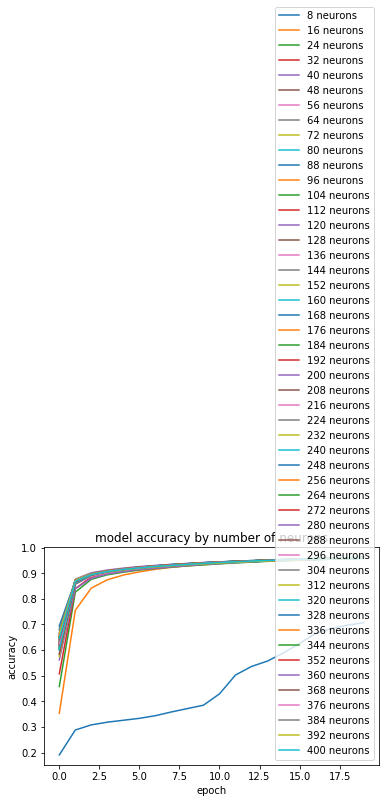

<Figure size 1296x1152 with 0 Axes>

In [ ]:
legend = []
if n_neurons == 0:
    for i in range(n_hlayers):
        plt.plot(total_history[i].history['acc'])
        legend.append('{} layers'.format(i+1))
    plt.legend(legend, loc='lower right')
    plt.title('model accuracy by layers')
else:
    for i in range(len(range(2, n_neurons, neurons_step))):
        plt.plot(total_history[i].history['acc'])
        legend.append('{} neurons'.format((i+1)*neurons_step))
    plt.legend(legend, loc='lower right')
    plt.title('model accuracy by number of neurons')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plot_name = "model_accuracy_by_{}".format(model_name)
#plt.savefig(plots_folder / plot_name)    
plt.figure(figsize=(18, 16))

Text(0.5,1,'model accuracy by fnn_fixed_layers')

Text(0,0.5,'accuracy')

Text(0.5,0,'layers')

<Figure size 1296x1152 with 0 Axes>

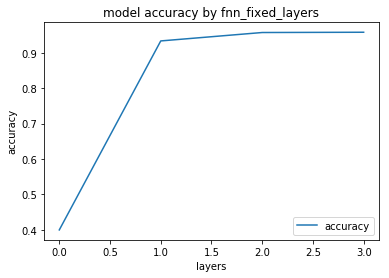

<Figure size 1296x1152 with 0 Axes>

In [68]:
accs = []
if n_neurons == 0:
    for i in range(n_hlayers):
        accs.append(total_history[i].history['acc'][-1])
else:
    for i in range(len(range(2, n_neurons, neurons_step))):
        accs.append(total_history[i].history['acc'][-1])
plt.plot(accs)
plt.legend(["accuracy"], loc='lower right')
plt.title('model accuracy by {}'.format(model_name))
plt.ylabel('accuracy')
plt.xlabel('layers')
plot_name = "model_accuracy_by_{}_end_train".format(model_name)
# plt.savefig(plots_folder / plot_name)
plt.figure(figsize=(18, 16))

**What is the impact of using more fully connected layers?**

Our original code will be rewrited in order to control the number of hidden layers via a global variables called *n_layers* and we will iterate adding that number of hidden layers and comparing the results for *Execution time*, *Accuracy* and *Overfit*.

**Observations**
1. **Loss / Accuracy**: As we increment the number of layers, usually the first epoch have more loss than the neural network with one less hidden layer but in the following epochs, this loss reduces greatly achieving better accuracy as more hidden layers are in the neural network.
2. **Execution time**: It can be seen that compiling time for each new architecture with more layers increases a little. The important one, training time, increases notably as we increment the number of layers. See the table.

3. **Overfitting**: An increment on the number of layers is translated to an overfit of the model to the train data in early epochs, meaning that as epochs go, more overfitted is the model.
4. It can be seen that the model accuracy increases as more layers are used.

    Compilation time  Training time
0           0.096816      47.962571
1           0.046975      48.235103
2           0.042444      48.411325
3           0.042291      53.318072
4           0.042862      55.063720
5           0.047598      53.644906
6           0.042339      53.117295
7           0.044225      55.598140
8           0.045431      55.785045
9           0.046777      55.671752
10          0.045471      56.889878
11          0.043127      58.835386
12          0.042396      55.970629
13          0.053397      55.750248
14          0.042777      55.446095
15          0.045554      55.505354
16          0.042679      61.191555
17          0.097888      57.406310
18          0.043692      70.076035
19          0.043320      66.213153
20          0.043814      70.696612
21          0.073000      69.192440
22          0.042162      71.173200
23          0.042000      63.222998
24          0.042118      67.784642
25          0.043888      73.656941
26          0.066471      73

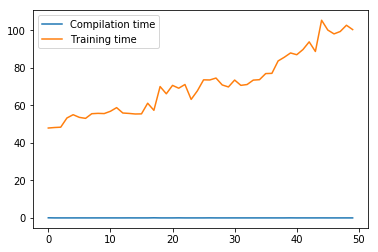

In [72]:
# compilation_time = [0.24594317327546378, 0.043510568686087936, 0.04459838010097883, 0.045250085238876636, 0.056358901495514147, 0.052324446456623264, 0.053702240227266884, 0.05874068365619678, 0.05362408092014448, 0.05278094211780626] 
# train_time = [39.99011794503713, 43.14482466451, 47.26708281148467, 49.6701730114778, 51.091938377238876, 51.03244404152338, 52.43567205865202, 55.833798198711065, 59.904547097023624, 61.02969902625591]

times_df = pd.DataFrame(times_dict)
print(times_df)
times_df.plot()

**What is the impact of increasing the number of neurons per layer?**

From increasing the number of neurons we can draw conclusions similar to the increase of the number of layers:
1. An increase in the overall of the training time.
2. As more neurons are used, higher is the accuracy.
3. Using more neurons seems to be **harder** to get overfitting issues compared to when increasing the number of layers, that makes the overfitting to happen earlier (in epochs).

**What is the best performance you can get out of a basic neural net?**

Because FNN can get good scores with the MNIST dataset, we will use the CIFAR10 dataset and try to achieve a good performance.

Using keras version 2.2.2


Number of training examples: '50000'
Number of test examples: '10000'
Size of train samples: '(32, 32, 3)'
--Call--
> c:\users\worldsensing\anaconda3\lib\site-packages\ipython\core\displayhook.py(247)__call__()
    246 
--> 247     def __call__(self, result=None):
    248         """Printing with history cache management.

ipdb> c
Epoch 1/20
50000/50000 [==============================] - 14s 275us/step - loss: 2.0359 - acc: 0.2152
Epoch 2/20
50000/50000 [==============================] - 14s 288us/step - loss: 1.8486 - acc: 0.3041
Epoch 3/20
50000/50000 [==============================] - 13s 260us/step - loss: 1.7761 - acc: 0.3476
Epoch 4/20
50000/50000 [==============================] - 15s 300us/step - loss: 1.7090 - acc: 0.3744
Epoch 5/20
50000/50000 [==============================] - 15s 303us/step - loss: 1.6575 - acc: 0.3985
Epoch 6/20
50000/50000 [==============================] - 16s 319us/step - loss: 1.6155 - acc: 0.4155
Epoch 7/20
50000/50000 [===

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

Analysis of results
              precision    recall  f1-score   support

           0       0.50      0.59      0.54      1000
           1       0.61      0.58      0.60      1000
           2       0.39      0.21      0.27      1000
           3       0.32      0.22      0.26      1000
           4       0.42      0.43      0.42      1000
           5       0.43      0.40      0.42      1000
           6       0.46      0.62      0.53      1000
           7       0.48      0.61      0.54      1000
           8       0.56      0.68      0.62      1000
           9       0.61      0.52      0.56      1000

   micro avg       0.49      0.49      0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000

[[589  27  39  22  31  10  31  51 162  38]
 [ 79 582   7  37  17   7  23  34  89 125]
 [108  23 212  67 196  94 140 110  40  10]
 [ 44  25  66 221  49 240 183  86  50  36]
 [ 65  13  89  38 430  43 147 132  33  10]
 [ 33 

FileNotFoundError: [Errno 2] No such file or directory: 'models\\fnn_cifar.json'

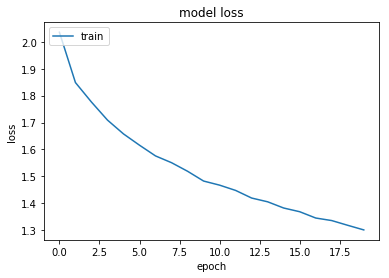

In [21]:
#NN architecture
# n_hlayers = 10
# n_neurons = 401

initial_neurons = 128
neurons = 200
layers = 10
neurons_step = 8
n_epochs= 40
n_batch_size= 128


#global variables
plots_folder = Path("plots/")
models_folder = Path("models/")
dataset_name = "cifar"
model_name = 'fnn_{}'.format(dataset_name)
cifar_nn_times_dict = {"Compilation time": [], "Training time": []}
cifar_fnn_total_history = []
text_file = "CIFAR-FNN score file.txt"
cifar_fnn_train_scores = []
cifar_fnn_evaluation_scores = []
start_time = time.clock()
print("Using keras version {0}".format(keras.__version__))

# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # loading of CIFAR10 dataset

# check sizes
print("\n")
print("Number of training examples: '{0}'".format(x_train.shape[0]))
print("Number of test examples: '{0}'".format(x_test.shape[0]))
print("Size of train samples: '{0}'".format(x_train.shape[1:]))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(50000,np.prod(x_train.shape[1:]))
x_test = x_test.reshape(10000, np.prod(x_train.shape[1:]))
bp()

# Adapts labels to one hot encoding vector for softmax classifier
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Neural network architecture
nn = Sequential()
nn.add(Dense(initial_neurons, activation='relu', input_shape=x_train.shape[1:]))
for i in range(layers):
    nn.add(Dense(neurons, activation = 'relu'))
nn.add(Dense(10, activation='softmax'))

# Compile the model
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = nn.fit(x_train, y_train, batch_size=128, epochs=20)

# Evaluate the model
score = nn.evaluate(x_test, y_test, verbose=0)

# Store plots
# Accuracy plot
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plot_name = 'model_accuracy_{0}.pdf'.format(model_name)
plt.savefig(plots_folder / plot_name)
plt.close()
# Loss plot
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plot_name = 'model_loss_{0}.pdf'.format(model_name)
plt.savefig(plots_folder / plot_name)

# Confusion Matrix
# Compute probabilities
Y_pred = nn.predict(test_input_shape)
# Assign most probable label
y_pred = np.argmax(Y_pred, axis=1)
# Plot statistics
print('Analysis of results')
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

# Saving model and weights
nn_json = nn.to_json()
json_file_name = '{0}.json'.format(model_name)
with open(models_folder / json_file_name, 'w') as json_file:
    json_file.write(nn_json)
weights_file_name = "weights-{0}_".format(model_name) + str(score[1]) + ".hdf5"
weights_file = models_folder / weights_file_name
nn.save_weights(weights_file, overwrite=True)

# Loading model and weights
json_file = open(models_folder / json_file_name, 'r')
nn_json = json_file.read()
json_file.close()
nn = model_from_json(nn_json)
nn.load_weights(weights_file)

#measuring execution time
print("Total execution time {} seconds".format(time.clock() - start_time))

## CNN

For the CNN part the CIFAR10 dataset will be used.

In [3]:
from __future__ import division
from pathlib import Path
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import ipdb
from ipdb import set_trace as bp

import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.utils import plot_model
from keras.models import model_from_json #to load a model from a json file.
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

np.random.seed(12345678)
%matplotlib inline

C:\Users\Worldsensing\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Worldsensing\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Worldsensing\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Worldsensing\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Worldsensing\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Worldsensing\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    io

In [ ]:
#global variables
plots_folder = Path("plots/")
models_folder = Path("models/")
times_dict = {"Compilation time": [], "Training time": []}
total_history = []
text_file = "CNN score file.txt"
train_scores = []
evaluation_scores = []

#neural net architecture config
n_hlayers = 0
n_neurons = 10
initial_neurons = 128
neurons_step = 2
n_epochs= 20
n_batch_size= 128
    
text_file =  model_name + "_" + text_file

start_time = time.clock()
print("Using keras version %s" % keras.__version__)

# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # loading of MNIST dataset

# check sizes
print("\n")
print("Number of training examples: '{0}'".format(x_train.shape[0]))
print("Number of test examples: '{0}'".format(x_test.shape[0]))
print("Size of train samples: '{0}'".format(x_train.shape[1:]))

# Data to 1D and normalization
#x_train = x_train.reshape(60000, 784)  # 60000 observations of 784 features
#x_test = x_test.reshape(10000, 784)  # 10000 observations of 784 features

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

train_input_shape = x_train.reshape(*x_train.shape)
test_input_shape = x_test.reshape(*x_test.shape)

# Adapts labels to one hot encoding vector for softmax classifier
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Neural network architecture
# CNN
nn = Sequential()
nn.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=x_train.shape[1:]))
nn.add(MaxPooling2D(pool_size=(2,2)))
nn.add(Conv2D(64,(3,3), activation = 'relu'))
nn.add(MaxPooling2D(pool_size=(2,2)))
nn.add(Flatten())
nn.add(Dense(128, activation='relu'))
nn.add(Dense(10, activation='softmax'))

# Model visualization
# The plot of the model needs pydot, graphviz and pydot-ng
#plot_model(nn, to_file='nn.png', show_shapes=True)

# Compile the model
nn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = nn.fit(train_input_shape, y_train, batch_size=128, epochs=20)

# Evaluate the model
score = nn.evaluate(test_input_shape, y_test, verbose=0)

# Store plots
# Accuracy plot
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plot_name = 'model_accuracy_{0}.pdf'.format(model_name)
plt.savefig(plots_folder / plot_name)
plt.close()
# Loss plot
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plot_name = 'model_loss_{0}.pdf'.format(model_name)
plt.savefig(plots_folder / plot_name)

# Confusion Matrix
# Compute probabilities
Y_pred = nn.predict(test_input_shape)
# Assign most probable label
y_pred = np.argmax(Y_pred, axis=1)
# Plot statistics
print('Analysis of results')
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

# Saving model and weights
nn_json = nn.to_json()
json_file_name = '{0}.json'.format(model_name)
with open(models_folder / json_file_name, 'w') as json_file:
    json_file.write(nn_json)
weights_file_name = "weights-{0}_".format(model_name) + str(score[1]) + ".hdf5"
weights_file = models_folder / weights_file_name
nn.save_weights(weights_file, overwrite=True)

# Loading model and weights
json_file = open(models_folder / json_file_name, 'r')
nn_json = json_file.read()
json_file.close()
nn = model_from_json(nn_json)
nn.load_weights(weights_file)

#measuring execution time
print("Total execution time {} seconds".format(time.clock() - start_time))

#### Questions
1. **Can you design and train a model that overfits on the training data (or on a subset of it)?**
2. **When overfitting, what is the result of applying various regularization techniques?**
3. **When using ReLUs, how many neurons are dead after a training?**
4. **Adding data augmentation improves performance?**
5. **How do the different learning algorithms behave for equal architectures? Does regularization have the same affect when using different algorithms?**
6. **How hard is it to match the performance of an adaptative algorithm (e.g., Adam) by using an algorithm where parameters have to be hand tunned (e.g., SGD)?**
7. **What is the result of using different weight initializations in the training process?**

## Experiments

### Self normalizing activation function

### Autoencoder

### House numbers, mnist and transer learning

### Loss function visualization